In [1]:
results="/home/c/dkorot/AI4GOOD/ai4good-mushroom/results/few_shot_table_all_backbones.csv"


In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv(results)


In [3]:
# Keep only rows where model is "zero-shot" or "prompt-prototype"
promt='prompt-prototype'
# promt='prototype'
filtered_df = df[df['model'].isin(['zero-shot', promt])]
filtered_df = filtered_df[df['split'].isin(['val'])]
filtered_df = filtered_df[~((filtered_df['model'] == promt) & (filtered_df['shot'] == 0))]
# filtered_df

/tmp/ipykernel_42410/2609432213.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[df['split'].isin(['val'])]


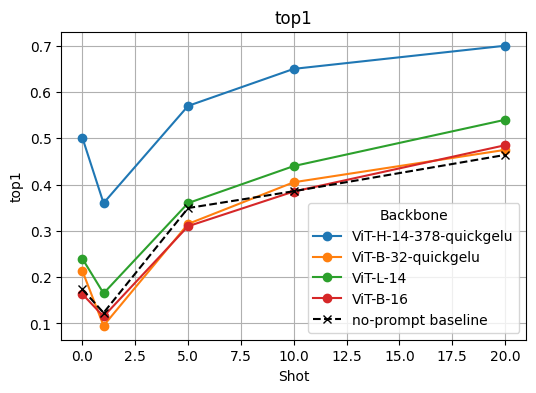

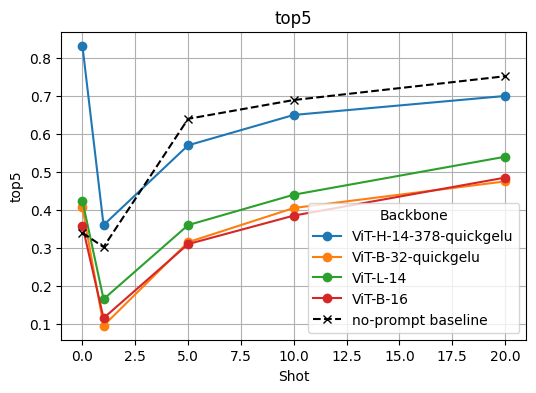

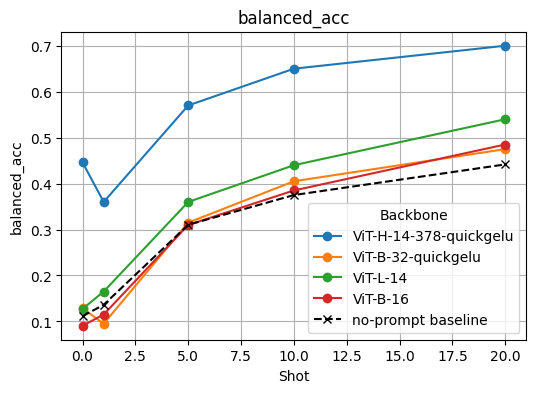

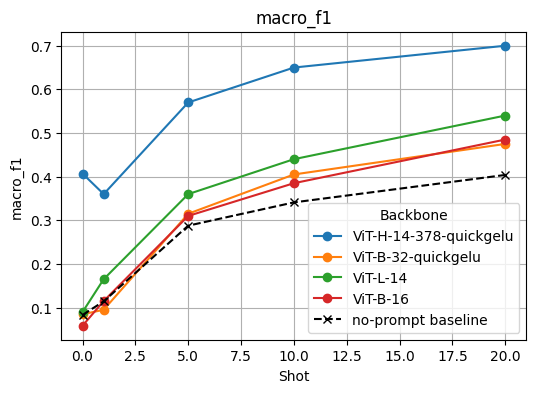

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is called filtered_df
accuracy_columns = ['top1', 'top5', 'balanced_acc', 'macro_f1']

# no_prompt_results_linear = {
# "top1": [0.17375432304342256, 0.14794415268348918, 0.4118099141795824, 0.4759190470090944, 0.5701934161649801],
# "top5": [0.3398872806455745, 0.3710772383758166, 0.7059049570897912, 0.7857051364160369, 0.8471884206481363],
# "balanced_acc": [0.11135393210618887, 0.15693212241062424, 0.3783356767488163, 0.4684481591264947, 0.555312425235222],
# "macro_f1": [0.08306181843795245, 0.1292491582531643, 0.3495973688573753, 0.42815230324569564, 0.5181250407800437]}

no_prompt_results_prompt = {
"top1": [0.17375432304342256, 0.12290252337645703, 0.3493019085436147, 0.3856154732931984, 0.46407070577686693],
"top5": [0.3398872806455745, 0.3021006788779301, 0.6398104265402843, 0.6893172793646727, 0.751953375176124],
"balanced_acc": [0.11135393210618887, 0.13618880148149493, 0.3103226373911458, 0.3750403797601285, 0.44167451571645827],
"macro_f1": [0.08306181843795245, 0.11428868692647248, 0.2876809967708631, 0.34099436563777863, 0.40388063876282854]}
no_prompt_results = no_prompt_results_prompt

for acc in accuracy_columns:
    plt.figure(figsize=(6,4))
    
    # Loop over unique backbones for plotting
    for backbone in filtered_df['backbone'].unique():
        subset = filtered_df[filtered_df['backbone'] == backbone]
        plt.plot(subset['shot'], subset[acc], marker='o', label=backbone)
    
    plt.plot([0, 1, 5, 10, 20], no_prompt_results[acc], marker='x', linestyle='--', color='black', label='no-prompt baseline')

    plt.title(f'{acc}')
    plt.xlabel('Shot')
    plt.ylabel(acc)
    plt.legend(title='Backbone')
    plt.grid(True)
    plt.show()


In [5]:
# import numpy as np


# top1 = {
#     "zero_shot": 0.17375432304342256,
#     "majority": 0.0071730492370782634,
#     "random": 0.0032662994748302804,
#     "shots": np.array([1, 5, 10, 20]),
#     "prototype": np.array([0.12290252337645703, 0.3493019085436147, 0.3856154732931984, 0.46407070577686693]),
#     "linear": np.array([0.14794415268348918, 0.4118099141795824, 0.4759190470090944, 0.5701934161649801])
# }
# top5 = {
#     "zero_shot": 0.3398872806455745,
#     "majority": 0.01556295632125016,
#     "random": 0.029585798816568046,
#     "shots": np.array([1, 5, 10, 20]),
#     "prototype": np.array([0.3021006788779301, 0.6398104265402843, 0.6893172793646727, 0.751953375176124]),
#     "linear": np.array([0.3710772383758166, 0.7059049570897912, 0.7857051364160369, 0.8471884206481363])
# }

# balanced_accuracy = {
#     "zero_shot": 0.11135393210618887,
#     "majority": 0.005917159763313609,
#     "random": 0.0069129044540821106,
#     "shots": np.array([1, 5, 10, 20]),
#     "prototype": np.array([0.13618880148149493, 0.3103226373911458, 0.3750403797601285, 0.44167451571645827]),
#     "linear": np.array([0.15693212241062424, 0.3783356767488163, 0.4684481591264947, 0.555312425235222])
# }

# macro_f1 = {
#     "zero_shot": 0.08306181843795245,
#     "majority": 3.852858575537748e-05,
#     "random": 0.0833629108554143,
#     "shots": np.array([1, 5, 10, 20]),
#     "prototype": np.array([0.11428868692647248, 0.2876809967708631, 0.34099436563777863, 0.40388063876282854]),
#     "linear": np.array([0.1292491582531643, 0.3495973688573753, 0.42815230324569564, 0.5181250407800437])
# }

# metrics = {
#     "Top-1 Accuracy": top1,
#     "Top-5 Accuracy": top5,
#     "Balanced Accuracy": balanced_accuracy,
#     "Macro F1": macro_f1
# }

In [6]:
# import matplotlib.pyplot as plt

# # Plot
# plt.figure(figsize=(8,5))
# plt.plot(shot_numbers, prototype, marker='o', linestyle='-', label='Prototype')
# plt.plot(shot_numbers, linear, marker='s', linestyle='-', label='Linear')
# plt.scatter(0, zero_shot, color='red', marker='x', label='Zero-shot')
# plt.scatter(0, majority, color='gray', marker='x', label='Majority')
# plt.scatter(0, random, color='lightgray', marker='x', label='Random')

# # Labels and formatting
# plt.title("Model Performance vs. Number of Shots (Top-1 Accuracy)")
# plt.xlabel("Number of Shots")
# plt.ylabel("Top-1 Accuracy")
# plt.xticks(shot_numbers)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Dictionaries (assuming they are already defined: top1, top5, balanced_accuracy, macro_f1)
# metrics = {
#     "Top-1 Accuracy": top1,
#     "Top-5 Accuracy": top5,
#     "Balanced Accuracy": balanced_accuracy,
#     "Macro F1": macro_f1
# }

# for metric_name, metric_data in metrics.items():
#     shot_numbers = metric_data["shots"]
#     prototype = metric_data["prototype"]
#     linear = metric_data["linear"]
#     zero_shot = metric_data["zero_shot"]
#     majority = metric_data["majority"]
#     random = metric_data["random"]
    
#     plt.figure(figsize=(8,5))
    
#     # Plot lines for prototype and linear
#     plt.plot(shot_numbers, prototype, marker='o', linestyle='-', label='Prototype')
#     plt.plot(shot_numbers, linear, marker='s', linestyle='-', label='Linear')
    
#     # Scatter for 0-shot models
#     plt.scatter(0, zero_shot, color='red', marker='x', s=100, label='Zero-shot')
#     plt.scatter(0, majority, color='gray', marker='x', s=100, label='Majority')
#     plt.scatter(0, random, color='lightgray', marker='x', s=100, label='Random')
    
#     # Labels and formatting
#     plt.title(f"Model Performance vs. Number of Shots ({metric_name})")
#     plt.xlabel("Number of Shots")
#     plt.ylabel(metric_name)
#     plt.xticks(np.insert(shot_numbers, 0, 0))  # Include 0-shot on x-axis
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
